라이브러리

In [17]:
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras.applications.xception as xception
import zipfile
import sys
import time
import tensorflow.keras as keras
import tensorflow as tf
import re

from PIL import Image
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
from keras.layers import Normalization # 이 부분 tensorflow 버전때문에 오류 떠서 바꿈
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.layers import Lambda
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

print('setup successful!')

setup successful!


이미지를 저장할 파일의 경로 설정

In [18]:
target_dir = './캡스톤폴더/images3'

In [20]:
# 파일 목록을 가져옵니다.
file_list = os.listdir("C:\\Users\\82106\\캡스톤\\캡스톤폴더\\images3")

# 파일 목록을 데이터프레임으로 변환합니다.
df_files = pd.DataFrame(file_list, columns=['filename'])

# 데이터프레임을 확인합니다.
df_files

,filename
0,battery1.jpg
1,battery10.jpg
2,battery100.jpg
3,battery101.jpg
4,battery102.jpg
...,...
13499,trash95.jpg
13500,trash96.jpg
13501,trash97.jpg
13502,trash98.jpg


In [21]:
# Increasing the image size didn't result in increasing the training accuracy
IMAGE_WIDTH = 320
IMAGE_HEIGHT = 320
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3


# Dictionary to save our 9 classes
categories = {0: 'battery', 1: 'biological', 2: 'cardboard', 3: 'clothes', 4: 'metal',
              5: 'paper', 6: 'plastic', 7: 'shoes', 8: 'trash'}

In [22]:
# 파일 이름에서 카테고리를 추출하고 해당하는 정수 인덱스를 찾는 함수
def extract_category_index(filename):
    # 파일 이름에서 카테고리 이름을 추출합니다.
    category_name = re.match(r'[a-zA-Z]+', filename).group()
    # categories 딕셔너리에서 해당 카테고리 이름의 키(정수 인덱스)를 찾습니다.
    for key, value in categories.items():
        if value == category_name:
            return key
    # 해당 카테고리가 딕셔너리에 없는 경우
    return None

# 카테고리별로 파일을 분류합니다.
df_files['category'] = df_files['filename'].apply(lambda x: extract_category_index(x))

# 데이터프레임을 섞습니다.
df_files = df_files.sample(frac=1).reset_index(drop=True)

print('number of elements = ', len(df_files))
df_files


number of elements =  13504


,filename,category
0,cardboard379.jpg,2
1,cardboard546.jpg,2
2,paper46.jpg,5
3,clothes5000.jpg,3
4,clothes687.jpg,3
...,...,...
13499,battery631.jpg,0
13500,paper959.jpg,5
13501,trash224.jpg,8
13502,clothes846.jpg,3


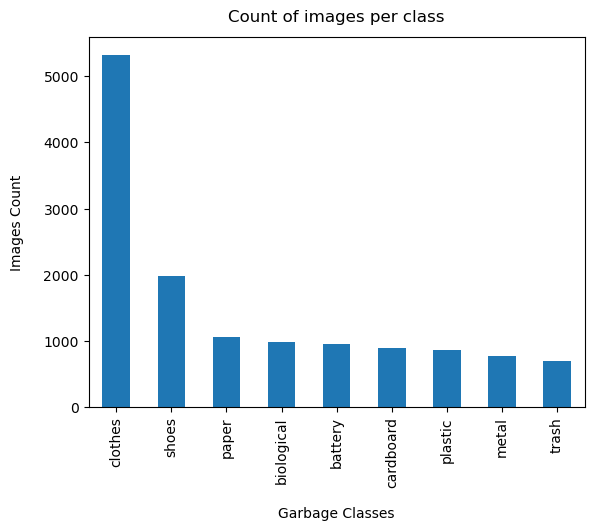

In [23]:
# 데이터의 분포 확인
df_visualization = df_files.copy()
# Change the catgegories from numbers to names
df_visualization['category'] = df_visualization['category'].apply(lambda x:categories[x] )

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Garbage Classes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of images per class", y=1.02);

사전 학습 모델을 이용한 전이학습

In [24]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
import keras.applications.xception as xception

xception_layer = xception.Xception(include_top = False, input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS),
                       weights = 'imagenet')

# We don't want to train the imported weights
xception_layer.trainable = False


model = Sequential()
model.add(keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))

#create a custom layer to apply the preprocessing
def xception_preprocessing(img):
    return xception.preprocess_input(img)

model.add(Lambda(xception_preprocessing))

model.add(xception_layer)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(len(categories), activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 320, 320, 3)       0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 9)                 18441     
                                                                 
Total params: 20,879,921
Trainable params: 18,441
Non-trainable params: 20,861,480
_________________________________________________________________


In [25]:
early_stop = EarlyStopping(patience = 2, verbose = 1, monitor='val_categorical_accuracy' , mode='max', min_delta=0.001, restore_best_weights = True)

callbacks = [early_stop]

In [26]:
#Change the categories from numbers to names
df_files["category"] = df_files["category"].replace(categories) 

# We first split the data into two sets and then split the validate_df to two sets
train_df, validate_df = train_test_split(df_files, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print('train size = ', total_validate , 'validate size = ', total_validate, 'test size = ', test_df.shape[0])

train size =  1350 validate size =  1350 test size =  1351


In [27]:
batch_size=64

train_datagen = image.ImageDataGenerator(
    
    ###  Augmentation Start  ###
    
    rotation_range=30,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2
    
    ##  Augmentation End  ###
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,  # train_df는 학습 데이터를 담고 있는 DataFrame
    target_dir,  # 위에서 설정한 절대 경로
    x_col='filename',  # 이미지 파일 이름
    y_col='category',  # 이미지 카테고리
    target_size=IMAGE_SIZE,  # 이미지의 타겟 크기
    class_mode='categorical',  # 다중 분류 설정
    batch_size=batch_size  # 배치 크기
)


Found 10803 validated image filenames belonging to 9 classes.


In [28]:
validation_datagen = image.ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    target_dir, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1350 validated image filenames belonging to 9 classes.


In [29]:
EPOCHS = 20
history = model.fit_generator(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/20
168/168 [==============================] - 2025s 12s/step - loss: 0.6016 - categorical_accuracy: 0.8423 - val_loss: 0.2317 - val_categorical_accuracy: 0.9449
Epoch 2/20
168/168 [==============================] - 1808s 11s/step - loss: 0.2653 - categorical_accuracy: 0.9248 - val_loss: 0.1675 - val_categorical_accuracy: 0.9561
Epoch 3/20
168/168 [==============================] - 1712s 10s/step - loss: 0.2139 - categorical_accuracy: 0.9367 - val_loss: 0.1483 - val_categorical_accuracy: 0.9606
Epoch 4/20
168/168 [==============================] - 2525s 15s/step - loss: 0.1903 - categorical_accuracy: 0.9452 - val_loss: 0.1375 - val_categorical_accuracy: 0.9613
Epoch 5/20
168/168 [==============================] - 1779s 11s/step - loss: 0.1737 - categorical_accuracy: 0.9454 - val_loss: 0.1301 - val_categorical_accuracy: 0.9621
Epoch 6/20
168/168 [==============================] - 2042s 12s/step - loss: 0.1628 - categorical_accuracy: 0.9508 - val_loss: 0.1228 - val_categorical_acc

전이 학습 모델 생성 후 저장

In [30]:
model.save_weights("model.cap_beta")

In [31]:
test_datagen = image.ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    directory=target_dir,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False 
)

Found 1351 validated image filenames belonging to 9 classes.


In [32]:
filenames = test_generator.filenames
nb_samples = len(filenames)

_, accuracy = model.evaluate_generator(test_generator, nb_samples)

print('accuracy on test set = ',  round((accuracy * 100),2 ), '% ') 

accuracy on test set =  95.78 % 
